In [1]:
%matplotlib inline

# Import custom scripts

In [2]:
path_scripts = '/Users/simjoo/Projects/10X_Skin/scripts/'

In [3]:
import sys
sys.path.append(path_scripts)

In [4]:
from Skin10X_misc_scripts_v1_4 import *
from Skin10X_plot_v1_0 import *
from Skin10X_affinity_propagation_v1_4 import *
from Skin10X_mann_whitney_u_v1_3 import *

/Users/simjoo/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from matplotlib.gridspec import GridSpec
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import ward
import pickle

In [6]:
from matplotlib_venn import venn3, venn3_circles

# Initialize engines

In [7]:
from ipyparallel import Client

In [8]:
c = Client(profile='default')

In [9]:
dview = c[:]

In [10]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/10X_Skin/scripts/")')
dview.execute('from Skin10X_affinity_propagation_v1_4 import *')
dview.execute('Skin10X_mann_whitney_u_v1_4 import *')

<AsyncResult: execute>

# Import Data

In [11]:
exp_id = '201806201840'
path_input = '/Users/simjoo/Projects/10X_Skin/data_input/v1.5/'
path_output = '/Users/simjoo/Projects/10X_Skin/data_output/v1.5'
path_figures = '/Users/simjoo/Projects/10X_Skin/figures/v1.5'

In [12]:
seq = loadData_v1(path_output, exp_id, 'seq', 'DataFrame')

In [13]:
seqN = loadData_v1(path_output, exp_id, 'seqN', 'DataFrame')

In [14]:
seqN_log2 = np.log2(seqN + 1)

In [15]:
cl_c_1st = loadData_v1(path_output, exp_id, 'cl_c_1st', 'Series')

In [16]:
cl_c_2nd = loadData_v1(path_output, exp_id, 'cl_c_2nd', 'Series')

In [17]:
cl_c_EPI = cl_c_2nd[[ix for ix in cl_c_2nd.index if cl_c_2nd[ix].split()[0] == 'EPI']]

In [18]:
tsne_1st = loadData_v1(path_output, exp_id, 'tsne_1st', 'DataFrame')

In [19]:
umap_EPI = loadData_v1(path_output, exp_id, 'umap_EPI', 'DataFrame')

In [20]:
mwu_av_EPI = loadData_v1(path_output, exp_id, 'mwu_av_epi', 'DataFrame')
mwu_gr_EPI = loadData_v1(path_output, exp_id, 'mwu_gr_epi', 'DataFrame')

In [21]:
mwu_av_2nd = loadData_v1(path_output, exp_id, 'mwu_av_2nd', 'DataFrame')
mwu_gr_2nd = loadData_v1(path_output, exp_id, 'mwu_gr_2nd', 'DataFrame')

In [22]:
cc_score_v2 = loadData_v1(path_output, exp_id, 'cc_score_v2','Series')

In [23]:
cells_stage = pd.Series([c[-2:] for c in seq.columns], index = seq.columns)

In [24]:
bc = loadData_v1(path_input, exp_id, 'assigned_barcodes', 'Series')
cells_replicate = pd.Series(index = seq.columns)
for ix in cells_replicate.index:
    if type(bc['%s-1' % ix[:-3]]) != str:
        cells_replicate[ix] = '%s unassigned' % ix.split('-')[-1]
    elif bc['%s-1' % ix[:-3]] == 'unassigned':
        cells_replicate[ix] = '%s unassigned' % ix.split('-')[-1]
    else:
        cells_replicate[ix] = bc['%s-1' % ix[:-3]]

In [25]:
path = '%s/%s_cmap_1st.pkl' % (path_output, exp_id)
f = open(path, 'rb')
cmap_1st = pickle.load(f)

In [26]:
path = '%s/%s_cmap_2nd.pkl' % (path_output, exp_id)
f = open(path, 'rb')
cmap_2nd = pickle.load(f)

In [27]:
cmap_time = {'5w':'#fb9a99','9w':'#b2df8a'}

In [28]:
markers_time = {'5w':'o','9w':'o'}

# tSNE - cell selection

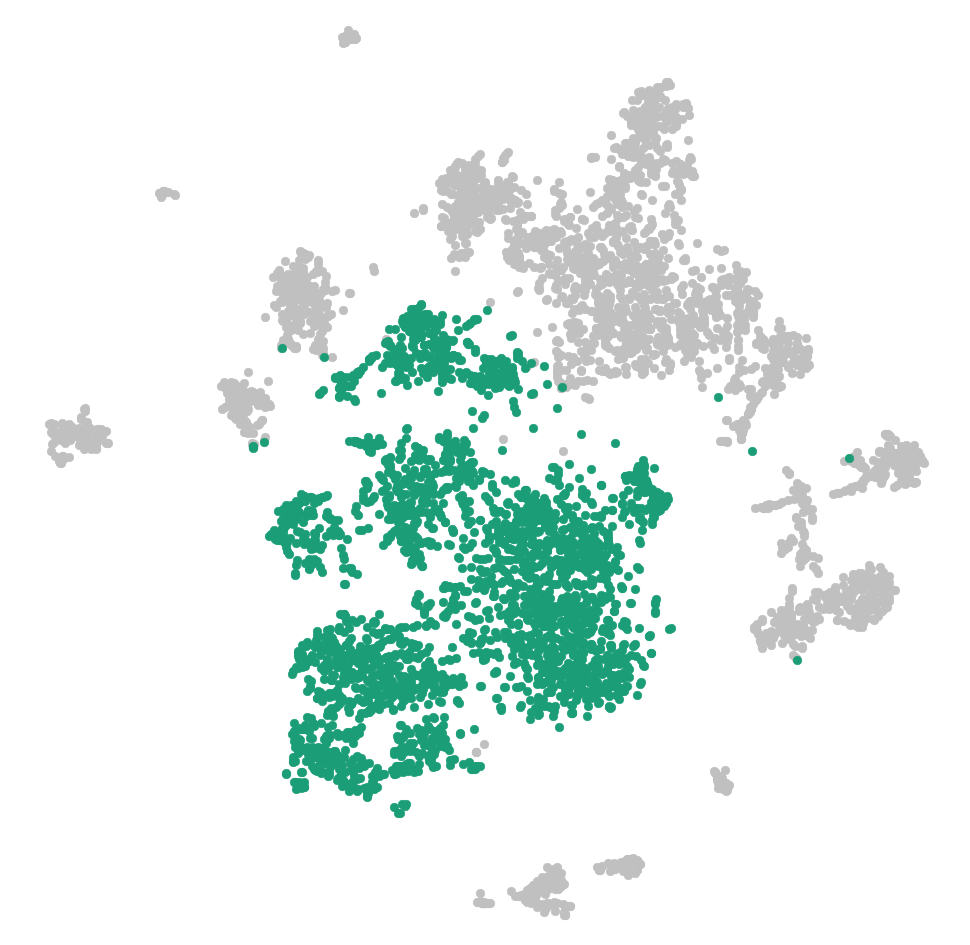

In [29]:
cells = cl_c_1st[cl_c_1st!='JUNK']
tsne = tsne_1st.loc[cells.index]
cmap = cmap_1st
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in [ix for ix in index if ix not in cl_c_EPI.index]:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 75,
                linewidth = 0.5,
                c = 'silver',
                edgecolor='silver', 
                marker = markers[time[ix]])
    
for ix in [ix for ix in index if ix in cl_c_EPI.index]:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 75,
                linewidth = 0.5,
                c = cmap_1st['EPI'],
                edgecolor=cmap_1st['EPI'], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig2_tSNE_epi_sel.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# tSNE - cell groups

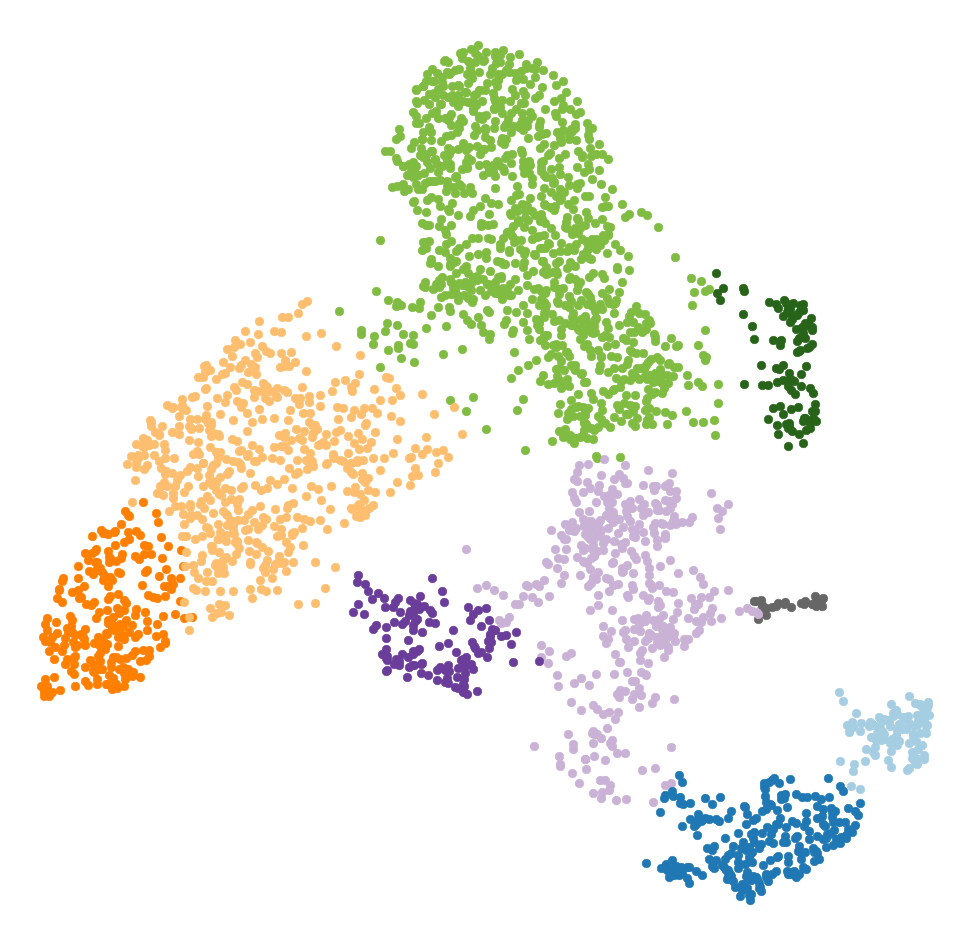

In [30]:
cells = cl_c_EPI
tsne = umap_EPI.loc[cells.index]
cmap = cmap_2nd
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 75,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig2_tSNE_epi.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# tSNE - time points

In [31]:
Counter(cells_stage[cl_c_EPI.index])

Counter({'9w': 1960, '5w': 851})

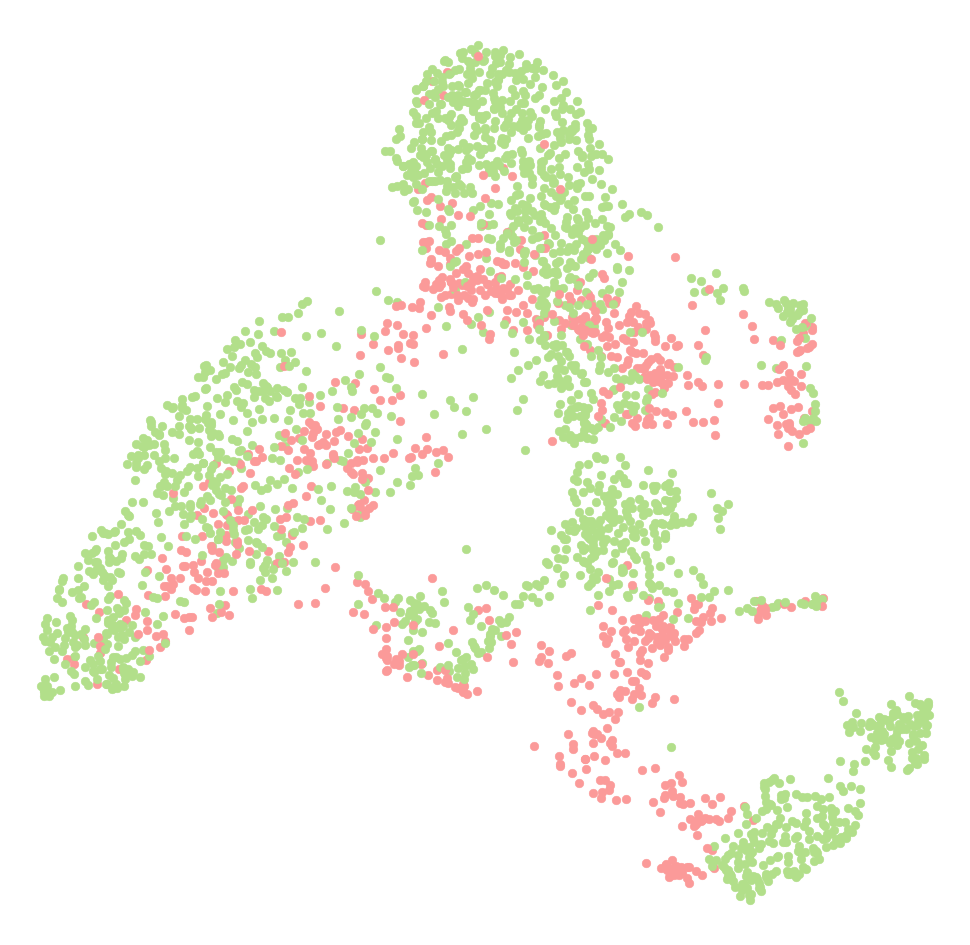

In [33]:
cells = cl_c_EPI
tsne = umap_EPI.loc[cells.index]
cmap = cmap_time
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 75,
                linewidth = 0.5,
                c = cmap[time[ix]],
                edgecolor=cmap[time[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig2_tSNE_epi_time.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# t-SNE - replicates

In [29]:
Counter(cells_replicate[cl_c_EPI.index])

Counter({'9wk1': 973,
         '9wk2': 882,
         '5wk2': 333,
         '5wk3': 154,
         '5wk1': 358,
         '9w unassigned': 105,
         '5w unassigned': 6})

In [30]:
cmap_replicate = {'9wk1':'#238b45',
                  '9wk2':'#74c476',
                  '9w unassigned':'#bae4b3',
                  '5wk1':'#cb181d',
                  '5wk2':'#fb6a4a',
                  '5wk3':'#fcae91',
                  '5w unassigned':'#fee5d9'}

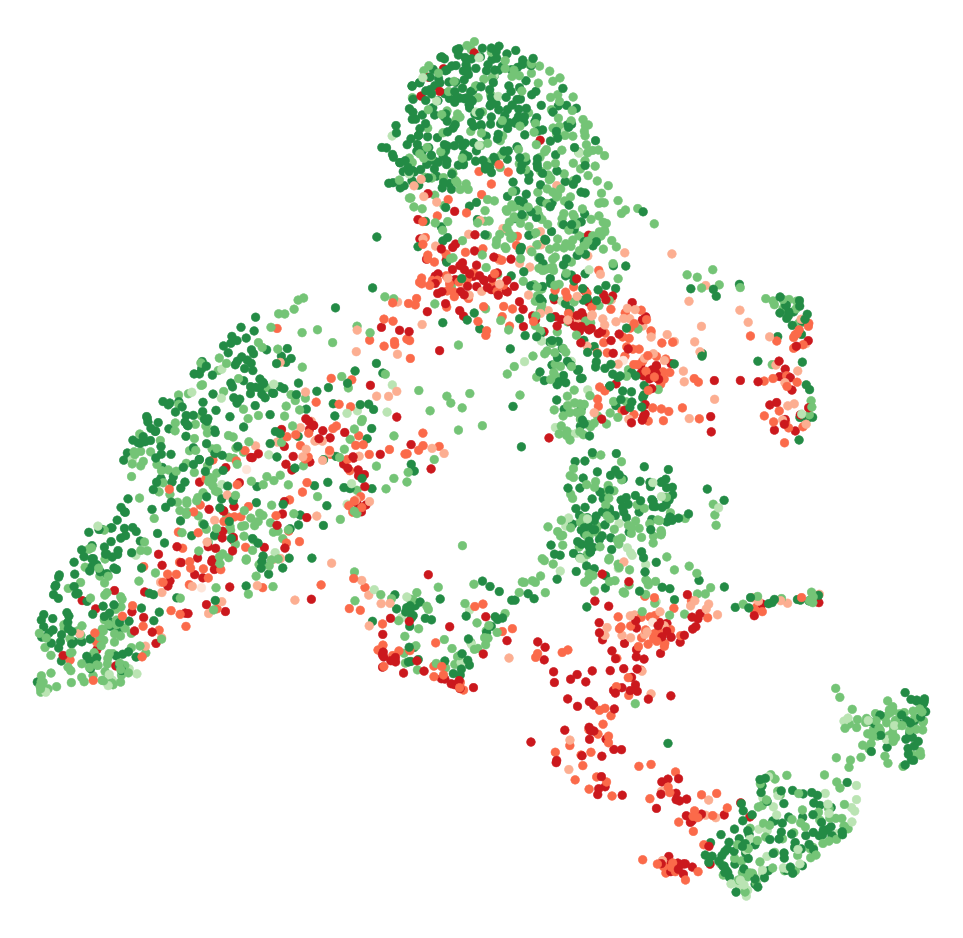

In [31]:
cells = cl_c_EPI
tsne = umap_EPI.loc[cells.index]
cmap = cmap_replicate
time = cells_replicate

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

clist = [cmap[time[i]] for i in index]

ax1.scatter(tsne.loc[index,'x'],
            tsne.loc[index,'y'], 
            s = 75,
            linewidth = 0.5,
            c = clist,
            edgecolor=clist)

clean_axis(ax1)

figname = 'v1.5_Fig6_tSNE_EPI_replicate.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

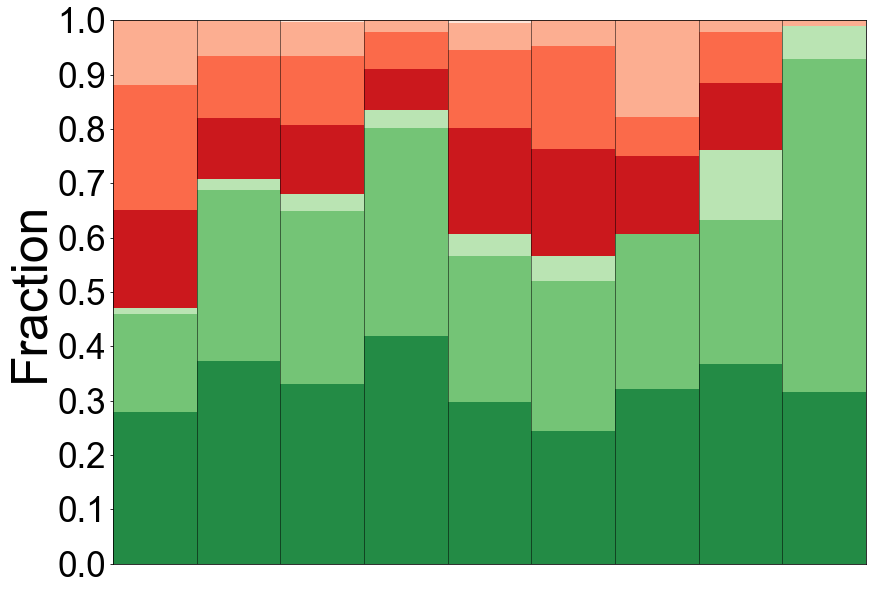

In [32]:
groups = cl_c_EPI
replicates = cells_replicate
cmap = cmap_replicate

#initialize figure

height = 10
width = len(return_unique(groups)) * 1.5

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#set axes

ax = plt.subplot(111)

ax.set_xlim(-0.5, len(return_unique(groups))-0.5)
ax.set_xticks([])

ax.set_ylim(0,1)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], family = 'Arial', fontsize = 35)
ax.set_ylabel('Fraction', fontsize = 50, family = 'Arial')

#get data

for pos, gr in enumerate(return_unique(groups)):
    c_tmp = groups[groups==gr].index
    l = len(c_tmp)
    rep_tmp = Counter(replicates[c_tmp])
    y = 0
    for r in ['9wk1','9wk2','9w unassigned','5wk1','5wk2','5wk3','5w unassigned']:
        y_new = y + rep_tmp[r]/l
        ax.bar(x = pos, bottom=y, height=y_new, width=1, color = cmap[r])
        y = y_new
    ax.axvline(pos+0.5, color = 'k', linewidth = 0.5)
    
figname = 'v1.5_Fig6_bar_EPI_replicate.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# t-SNE - cell cycle

In [34]:
Counter(cc_score_v2.loc[cl_c_EPI.index])

Counter({'G2M': 176, 'G1': 2538, 'S': 97})

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


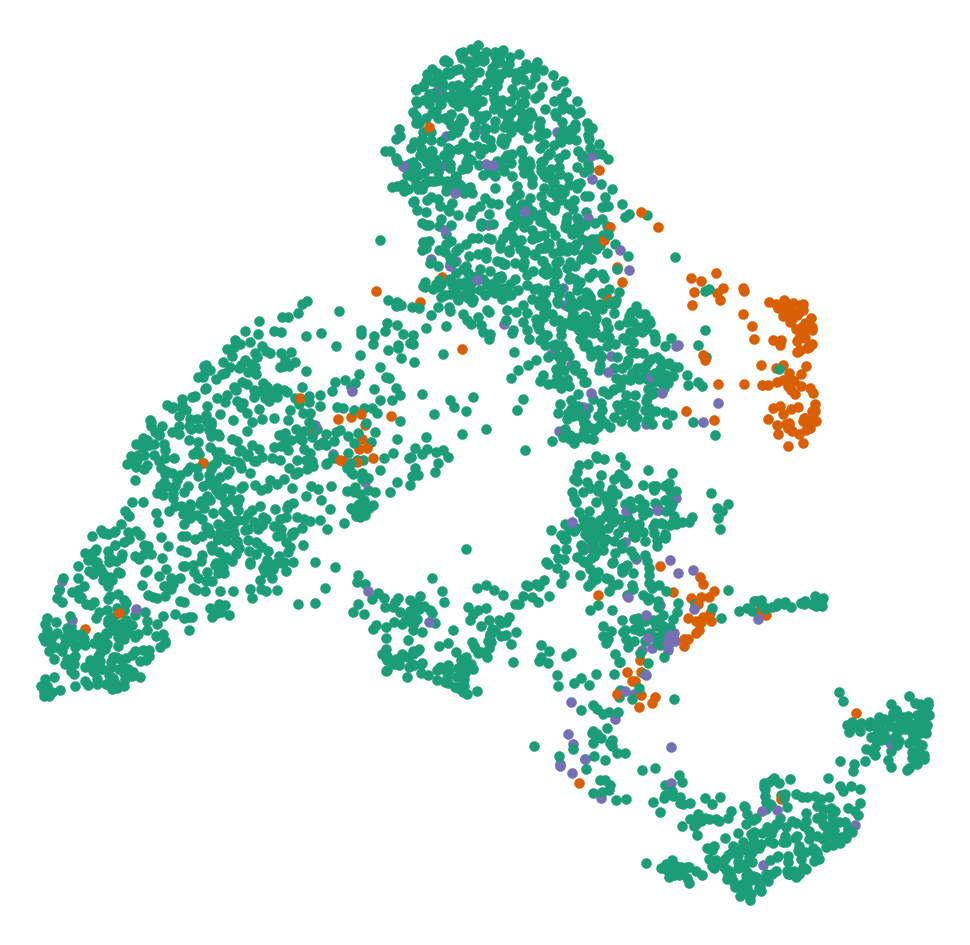

In [35]:
data = cc_score_v2.loc[cl_c_EPI.index]
cells = cl_c_EPI
tsne = umap_EPI.ix[cells.index]
cmap = {'G1':'#1b9e77','G2M':'#d95f02','S':'#7570b3'}
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

for ix in tsne.index:

    ax1.scatter(tsne.ix[ix,'x'],
                tsne.ix[ix,'y'], 
                s = 100,
                linewidth = 0.5,
                c = cmap[data[ix]],
                edgecolor=cmap[data[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_Fig2_EPI_CC_class.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Marker genes

In [29]:
def get_cluster_ticks(cl):

    ticks = []
    cnt = 0
    
    for i in return_unique(cl):
        l = Counter(cl)[i]
        ticks += [cnt + l / 2]
        cnt += l
        
    return ticks

In [30]:
genes = ['Ccnb1','Cdk1',
         'Krt14','Fth1',
         'Krt10','Krtdap',
         'Sostdc1','Apoe',
         'Krt79','Krt17',
         'Cidea','Mgst1',
         'Cd34','Postn',
         'Id1','Id3']

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


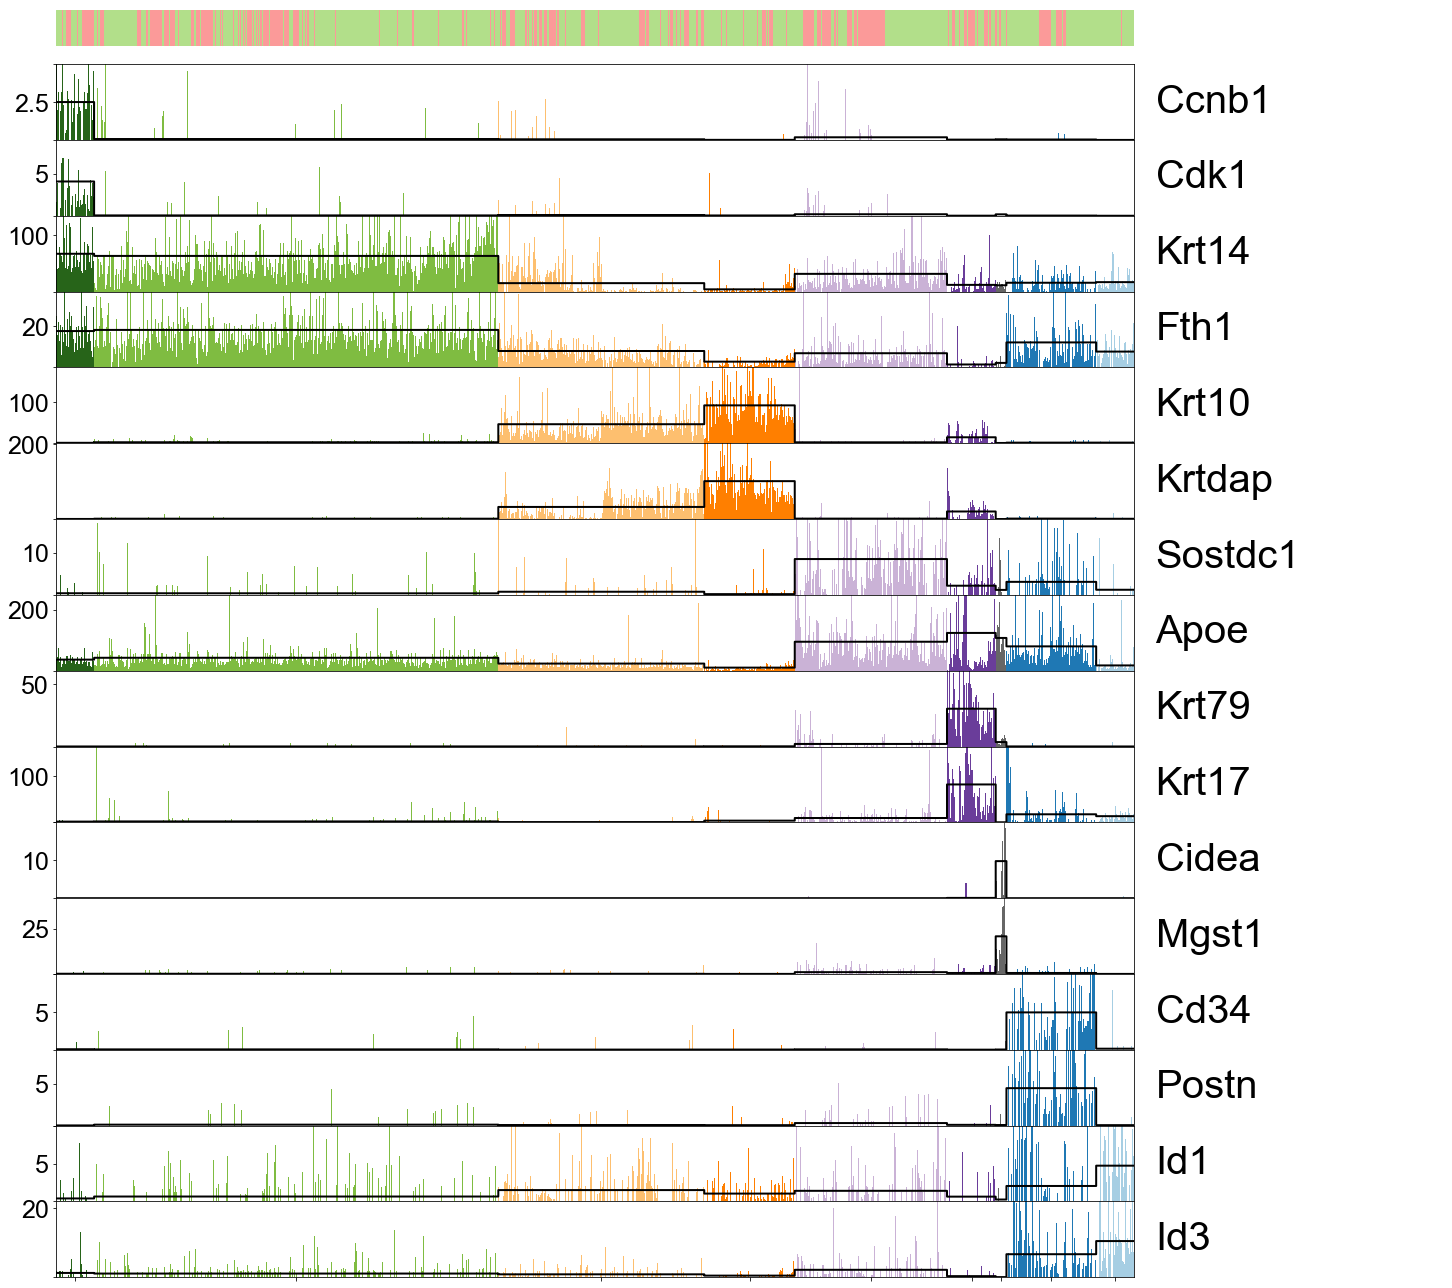

In [31]:
cell_groups = cl_c_EPI
dataset = seqN[cl_c_EPI.index]
#genes = ['Cldn10','Lhx2']
cmap = cmap_2nd

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 20
height = len(genes) * 1.1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticks(get_cluster_ticks(cell_groups))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 40, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        ax0.locator_params(axis='y', nbins=2)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for pos, c in enumerate(cell_groups.index):
    
    ax1.axvspan(xmin = pos, xmax = pos + 1, color = cmap_time[cells_stage[c]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

figname = 'v1.5_Fig2_bar_markers.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Enrichment of cell cycle cells

In [49]:
c_sel_IFEB = cl_c_EPI[cl_c_EPI.isin(['EPI - 0','EPI - 1'])].index
c_sel_uHFB = cl_c_EPI[cl_c_EPI.isin(['EPI - 4'])].index

In [50]:
c_sel_IFEB_SG2M = cc_score_v2.loc[c_sel_IFEB][cc_score_v2.loc[c_sel_IFEB].isin(['S','G2M'])].index
c_sel_uHFB_SG2M = cc_score_v2.loc[c_sel_uHFB][cc_score_v2.loc[c_sel_uHFB].isin(['S','G2M'])].index

In [51]:
cl_c_SG2M = pd.Series(index = list(c_sel_IFEB_SG2M) + list(c_sel_uHFB_SG2M))
cl_c_SG2M[c_sel_IFEB_SG2M] = 'IFEB'
cl_c_SG2M[c_sel_uHFB_SG2M] = 'uHFB'

In [52]:
Counter(cl_c_SG2M)

Counter({'IFEB': 163, 'uHFB': 72})

In [53]:
cc_quant_2nd = pd.DataFrame(index = return_unique(cl_c_SG2M), columns = ['count anagen',
                                                                           '% anagen',
                                                                           'count telogen',
                                                                           '% telogen',
                                                                           'proba - 5w',
                                                                           'proba - 9w'])

for gr in return_unique(cl_c_SG2M):
    c_sel = cl_c_SG2M[cl_c_SG2M==gr].index
    count_tmp = Counter(cells_stage[c_sel])
    
    cc_quant_2nd.loc[gr,'count anagen'] = count_tmp['5w']
    cc_quant_2nd.loc[gr,'% anagen'] = cc_quant_2nd.loc[gr,'count anagen'] / len(c_sel)
    cc_quant_2nd.loc[gr,'count telogen'] = count_tmp['9w']
    cc_quant_2nd.loc[gr,'% telogen'] = cc_quant_2nd.ix[gr,'count telogen'] / len(c_sel)
    cc_quant_2nd.loc[gr,['proba - 9w','proba - 5w']] = stage_get_pval_binomial_distr(len(c_sel), perc_anagen_all, cc_quant_2nd.ix[gr,'count anagen'])

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


In [54]:
cc_quant_2nd

count anagen  % anagen count telogen % telogen   proba - 5w proba - 9w
IFEB           69  0.423313            94  0.576687  0.000545295   0.999696
uHFB           48  0.666667            24  0.333333  1.47988e-10          1

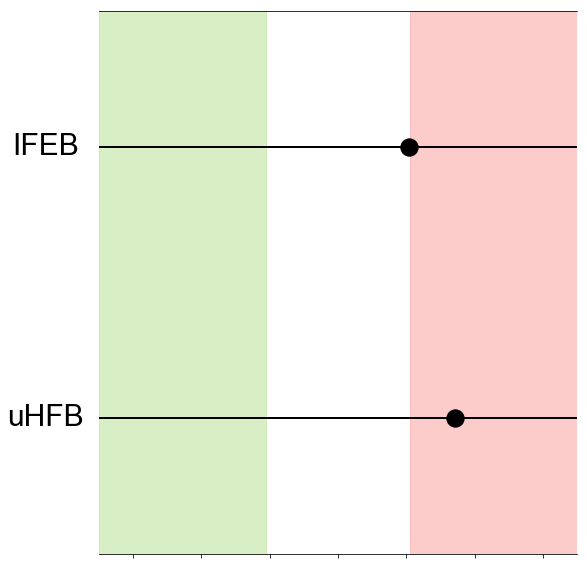

In [55]:
#define input variables

groups = return_unique(cl_c_SG2M)
L = len(groups)
pval_ana = -np.log10(cc_quant_2nd.loc[groups,'proba - 5w'].astype(float))
pval_tel = -np.log10(cc_quant_2nd.loc[groups,'proba - 9w'].astype(float))
cmap = cmap_time


#initialize figure

height = 10
width = 10

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1, 2, hspace = 0.0, wspace = 0.1, width_ratios = [1,9])

#create name axis 
    
ax0 = plt.subplot(gs[0,0])
ax0.set_ylim(L - 0.5, -0.5)
clean_axis(ax0)

#create pval axes
    
ax1 = plt.subplot(gs[0,1])
ax1.spines['left'].set_color('none')
ax1.spines['right'].set_color('none')
ax1.set_ylim(L - 0.5, -0.5)
ax1.yaxis.set_ticks_position('right')
ax1.yaxis.set_ticks([])

#iterate over groups
    
for ix, gr in enumerate(groups):
    ax0.text(0.5, ix, gr, family = 'Arial', fontsize = 30, ha = 'center', va = 'center')
    ax1.axhline(ix, color = 'k', lw = 2)
    """    
    #print background
        
    if ix % 2 == 0:
        ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
        ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
    if ix % 2 == 1:
        ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
        ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
    """    
    #print pvals

    if pval_ana[gr] < pval_tel[gr]:
        ax1.scatter(-np.log2(pval_tel[gr]+1), ix, marker = 'o', s = 300, color = 'black', zorder = 2)
        
    if pval_ana[gr] > pval_tel[gr]:
        ax1.scatter(np.log2(pval_ana[gr]+1), ix, marker = 'o', s = 300, color = 'black', zorder = 2)
        
#set xaxis

xmin = -7
xmax = 7

ticklabels = ['$10^{-64}$','$10^{-16}$','$10^{-4}$','$0$','$10^{-4}$','$10^{-16}$','$10^{-64}$']

ax1.set_xlim(xmin, xmax)
ax1.set_xticks([-6,-4,-2,0,2,4,6])
ax1.set_xticklabels([])

#set significance tresholds

thr = np.log2(-np.log10(0.001/2)+1) #bonferroni corrected

ax1.axvspan(-7,
            -thr,
            color = cmap['9w'], alpha = 0.5)

ax1.axvspan(thr,
            7,
            color = cmap['5w'], alpha = 0.5)

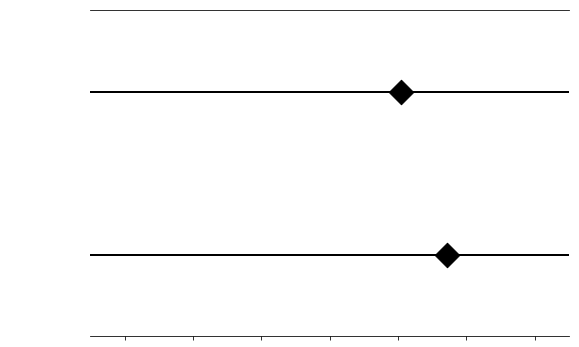

In [56]:
#define input variables

groups = return_unique(cl_c_SG2M)
L = len(groups)
pval_ana = -np.log10(cc_quant_2nd.loc[groups,'proba - 5w'].astype(float))
pval_tel = -np.log10(cc_quant_2nd.loc[groups,'proba - 9w'].astype(float))
cmap = cmap_time


#initialize figure

height = L * 3
width = 10

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(1, 2, hspace = 0.0, wspace = 0.1, width_ratios = [1,9])

#create name axis 
    
ax0 = plt.subplot(gs[0,0])
ax0.set_ylim(L - 0.5, -0.5)
clean_axis(ax0)

#create pval axes
    
ax1 = plt.subplot(gs[0,1])
ax1.spines['left'].set_color('none')
ax1.spines['right'].set_color('none')
ax1.set_ylim(L - 0.5, -0.5)
ax1.yaxis.set_ticks_position('right')
ax1.yaxis.set_ticks([])

#iterate over groups
    
for ix, gr in enumerate(groups):
    #ax0.text(0.5, ix, nmap[gr], family = 'Arial', fontsize = 30, ha = 'center', va = 'center')
    ax1.axhline(ix, color = 'k', lw = 2)
        
    #print background
    """    
    if ix % 2 == 0:
        ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
        ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
    if ix % 2 == 1:
        ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
        ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
    """    
    #print pvals

    if pval_ana[gr] < pval_tel[gr]:
        ax1.scatter(-np.log2(pval_tel[gr]+1), ix, marker = 'D', s = 300, color = 'black', zorder = 2)
        
    if pval_ana[gr] > pval_tel[gr]:
        ax1.scatter(np.log2(pval_ana[gr]+1), ix, marker = 'D', s = 300, color = 'black', zorder = 2)
        
#set xaxis

xmin = -7
xmax = 7

ticklabels = ['$10^{-64}$','$10^{-16}$','$10^{-4}$','$0$','$10^{-4}$','$10^{-16}$','$10^{-64}$']

ax1.set_xlim(xmin, xmax)
ax1.set_xticks([-6,-4,-2,0,2,4,6])
ax1.set_xticklabels([])

#set significance tresholds

thr = np.log2(-np.log10(0.001/2)+1) #bonferroni corrected
"""
ax1.axvspan(-7,
            -thr,
            color = cmap['9w'], alpha = 0.5)

ax1.axvspan(thr,
            7,
            color = cmap['5w'], alpha = 0.5)
"""

#plot for combination with illustrator gradient

ax1.axvspan(-thr,
            thr,
            color = 'white', alpha = 1)

figname = 'v1.5_Fig2_enr_cc_EPI.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Compare anagen-telogen gene expression (within compartment)

In [57]:
c_sel_IFEC = cl_c_EPI[cl_c_EPI=='EPI - 0'].index
c_sel_IFEC_A = cells_stage[c_sel_IFEC][cells_stage[c_sel_IFEC] == '5w'].index
c_sel_IFEC_T = cells_stage[c_sel_IFEC][cells_stage[c_sel_IFEC] == '9w'].index

c_sel_IFEB = cl_c_EPI[cl_c_EPI=='EPI - 1'].index
c_sel_IFEB_A = cells_stage[c_sel_IFEB][cells_stage[c_sel_IFEB] == '5w'].index
c_sel_IFEB_T = cells_stage[c_sel_IFEB][cells_stage[c_sel_IFEB] == '9w'].index

c_sel_IFED = cl_c_EPI[cl_c_EPI=='EPI - 2'].index
c_sel_IFED_A = cells_stage[c_sel_IFED][cells_stage[c_sel_IFED] == '5w'].index
c_sel_IFED_T = cells_stage[c_sel_IFED][cells_stage[c_sel_IFED] == '9w'].index

c_sel_IFEM = cl_c_EPI[cl_c_EPI=='EPI - 3'].index
c_sel_IFEM_A = cells_stage[c_sel_IFEM][cells_stage[c_sel_IFEM] == '5w'].index
c_sel_IFEM_T = cells_stage[c_sel_IFEM][cells_stage[c_sel_IFEM] == '9w'].index

c_sel_uHFB = cl_c_EPI[cl_c_EPI=='EPI - 4'].index
c_sel_uHFB_A = cells_stage[c_sel_uHFB][cells_stage[c_sel_uHFB] == '5w'].index
c_sel_uHFB_T = cells_stage[c_sel_uHFB][cells_stage[c_sel_uHFB] == '9w'].index

c_sel_uHFD = cl_c_EPI[cl_c_EPI=='EPI - 5'].index
c_sel_uHFD_A = cells_stage[c_sel_uHFD][cells_stage[c_sel_uHFD] == '5w'].index
c_sel_uHFD_T = cells_stage[c_sel_uHFD][cells_stage[c_sel_uHFD] == '9w'].index

c_sel_OB = cl_c_EPI[cl_c_EPI=='EPI - 7'].index
c_sel_OB_A = cells_stage[c_sel_OB][cells_stage[c_sel_OB] == '5w'].index
c_sel_OB_T = cells_stage[c_sel_OB][cells_stage[c_sel_OB] == '9w'].index

In [58]:
genes_sel = dropNull_v2X(seqN[cl_c_EPI.index], None, 0.025).index


Dropping unexpressed genes from dataset


In [59]:
len(genes_sel)

8024

In [60]:
thr = -np.log10(0.001)

In [61]:
scale_log = np.log2(seq+1).sum() / np.log2(seq+1).sum().median()
seq_log_sc = np.log2(seq+1) / scale_log

### Downsample data

In [62]:
import scanpy.api as sc

In [63]:
def to_scanpy(df):
    
    X = df
    obs = pd.DataFrame()
    obs['CellID'] = X.columns
    var = pd.DataFrame()
    var['Gene'] = X.index
    scdata = sc.AnnData(np.array(X.T), obs = obs, var = var)

    return scdata

In [64]:
c_sel_5w = cells_stage.loc[cl_c_EPI.index][cells_stage.loc[cl_c_EPI.index]=='5w'].index
c_sel_9w = cells_stage.loc[cl_c_EPI.index][cells_stage.loc[cl_c_EPI.index]=='9w'].index

In [65]:
seq_EPI = seq[cl_c_EPI.index]

In [66]:
scdata_EPI = to_scanpy(seq_EPI)

In [159]:
sc.pp.downsample_counts(scdata_EPI, target_counts=1000)

In [160]:
seq_EPI_ds = pd.DataFrame(scdata_EPI.X.T, index = scdata_EPI.var['Gene'], columns = scdata_EPI.obs['CellID'])

In [161]:
seq_EPI_ds = seq_EPI_ds[seq_EPI_ds.sum()[seq_EPI_ds.sum()==1000].index]

In [162]:
Counter(cells_stage[seq_EPI_ds.columns])

Counter({'9w': 1624, '5w': 851})

In [163]:
Counter(cells_stage[cl_c_EPI.index])

Counter({'9w': 1960, '5w': 851})

## IFE cycling

In [164]:
sf_IFEC = loadData_v1(path_output, exp_id, 'sf_IFEC', 'DataFrame')
sf_IFEC.index = [ix.replace('.','-') for ix in sf_IFEC.index]

In [165]:
seqN_IFEC = seq[c_sel_IFEC] / sf_IFEC

In [166]:
cl_c_AT_IFEC = pd.Series(index = c_sel_IFEC)
cl_c_AT_IFEC[c_sel_IFEC_A] = 'A'
cl_c_AT_IFEC[c_sel_IFEC_T] = 'T'

In [167]:
Counter(cl_c_AT_IFEC)

Counter({'T': 47, 'A': 53})

In [168]:
MWU_av_AT_IFEC = MWU_vs_average(np.log2(seqN_IFEC+1), cl_c_AT_IFEC, genes_sel, dview)

In [169]:
(MWU_av_AT_IFEC > thr).sum()

T     4
A    10
dtype: int64

In [170]:
MWU_av_AT_IFEC_sc = MWU_vs_average(seq_log_sc, cl_c_AT_IFEC, genes_sel, dview)

In [171]:
(MWU_av_AT_IFEC_sc > thr).sum()

T    51
A     1
dtype: int64

In [172]:
c_sel = [c for c in seq_EPI_ds.columns if c in cl_c_AT_IFEC.index]

In [173]:
MWU_av_AT_IFEC_ds = MWU_vs_average(seq_EPI_ds, cl_c_AT_IFEC[c_sel], genes_sel, dview)

In [174]:
(MWU_av_AT_IFEC_ds > -np.log10(0.05)).sum()

T    2
A    0
dtype: int64

## IFE basal

In [175]:
sf_IFEB = loadData_v1(path_output, exp_id, 'sf_IFEB', 'DataFrame')
sf_IFEB.index = [ix.replace('.','-') for ix in sf_IFEB.index]

In [176]:
seqN_IFEB = seq[c_sel_IFEB] / sf_IFEB

In [177]:
cl_c_AT_IFEB = pd.Series(index = c_sel_IFEB)
cl_c_AT_IFEB[c_sel_IFEB_A] = 'A'
cl_c_AT_IFEB[c_sel_IFEB_T] = 'T'

In [178]:
Counter(cl_c_AT_IFEB)

Counter({'T': 746, 'A': 308})

In [179]:
MWU_av_AT_IFEB = MWU_vs_average(np.log2(seqN_IFEB+1), cl_c_AT_IFEB, genes_sel, dview)

In [180]:
(MWU_av_AT_IFEB > thr).sum()

T      59
A    3401
dtype: int64

In [181]:
MWU_av_AT_IFEB_sc = MWU_vs_average(seq_log_sc, cl_c_AT_IFEB, genes_sel, dview)

In [182]:
(MWU_av_AT_IFEB_sc > thr).sum()

T     158
A    3175
dtype: int64

In [183]:
c_sel = [c for c in seq_EPI_ds.columns if c in cl_c_AT_IFEB.index]

In [184]:
MWU_av_AT_IFEB_ds = MWU_vs_average(seq_EPI_ds, cl_c_AT_IFEB[c_sel], genes_sel, dview)

In [185]:
(MWU_av_AT_IFEB_ds > -np.log10(0.05)).sum()

T     42
A    205
dtype: int64

## IFE differentiating

In [186]:
sf_IFED = loadData_v1(path_output, exp_id, 'sf_IFED', 'DataFrame')
sf_IFED.index = [ix.replace('.','-') for ix in sf_IFED.index]

In [187]:
seqN_IFED = seq[c_sel_IFED] / sf_IFED

In [188]:
cl_c_AT_IFED = pd.Series(index = c_sel_IFED)
cl_c_AT_IFED[c_sel_IFED_A] = 'A'
cl_c_AT_IFED[c_sel_IFED_T] = 'T'

In [189]:
Counter(cl_c_AT_IFED)

Counter({'A': 172, 'T': 365})

In [190]:
MWU_av_AT_IFED = MWU_vs_average(np.log2(seqN_IFED+1), cl_c_AT_IFED, genes_sel, dview)

In [191]:
(MWU_av_AT_IFED > thr).sum()

A    3580
T      31
dtype: int64

In [192]:
MWU_av_AT_IFED_sc = MWU_vs_average(seq_log_sc, cl_c_AT_IFED, genes_sel, dview)

In [193]:
(MWU_av_AT_IFED_sc > thr).sum()

A    3385
T     138
dtype: int64

In [194]:
c_sel = [c for c in seq_EPI_ds.columns if c in cl_c_AT_IFED.index]

In [195]:
MWU_av_AT_IFED_ds = MWU_vs_average(seq_EPI_ds, cl_c_AT_IFED[c_sel], genes_sel, dview)

In [196]:
(MWU_av_AT_IFED_ds > -np.log10(0.05)).sum()

A    53
T    14
dtype: int64

## IFE mature

In [197]:
sf_IFEM = loadData_v1(path_output, exp_id, 'sf_IFEM', 'DataFrame')
sf_IFEM.index = [ix.replace('.','-') for ix in sf_IFEM.index]

In [198]:
seqN_IFEM = seq[c_sel_IFEM] / sf_IFEM

In [199]:
cl_c_AT_IFEM = pd.Series(index = c_sel_IFEM)
cl_c_AT_IFEM[c_sel_IFEM_A] = 'A'
cl_c_AT_IFEM[c_sel_IFEM_T] = 'T'

In [200]:
Counter(cl_c_AT_IFEM)

Counter({'T': 197, 'A': 39})

In [201]:
MWU_av_AT_IFEM = MWU_vs_average(np.log2(seqN_IFEM+1), cl_c_AT_IFEM, genes_sel, dview)

In [202]:
(MWU_av_AT_IFEM > thr).sum()

T       9
A    1074
dtype: int64

In [203]:
MWU_av_AT_IFEM_sc = MWU_vs_average(seq_log_sc, cl_c_AT_IFEM, genes_sel, dview)

In [204]:
(MWU_av_AT_IFEM_sc > thr).sum()

T     42
A    780
dtype: int64

In [205]:
c_sel = [c for c in seq_EPI_ds.columns if c in cl_c_AT_IFEM.index]

In [206]:
MWU_av_AT_IFEM_ds = MWU_vs_average(seq_EPI_ds, cl_c_AT_IFEM[c_sel], genes_sel, dview)

In [207]:
(MWU_av_AT_IFEM_ds > -np.log10(0.05)).sum()

T     2
A    36
dtype: int64

## uHF basal

In [208]:
sf_uHFB = loadData_v1(path_output, exp_id, 'sf_uHFB', 'DataFrame')
sf_uHFB.index = [ix.replace('.','-') for ix in sf_uHFB.index]

In [209]:
seqN_uHFB = seq[c_sel_uHFB] / sf_uHFB

In [210]:
cl_c_AT_uHFB = pd.Series(index = c_sel_uHFB)
cl_c_AT_uHFB[c_sel_uHFB_A] = 'A'
cl_c_AT_uHFB[c_sel_uHFB_T] = 'T'

In [211]:
Counter(cl_c_AT_uHFB)

Counter({'T': 241, 'A': 156})

In [212]:
MWU_av_AT_uHFB = MWU_vs_average(np.log2(seqN_uHFB+1), cl_c_AT_uHFB, genes_sel, dview)

In [213]:
(MWU_av_AT_uHFB > thr).sum()

T      33
A    6166
dtype: int64

In [214]:
MWU_av_AT_uHFB_sc = MWU_vs_average(seq_log_sc, cl_c_AT_uHFB, genes_sel, dview)

In [215]:
(MWU_av_AT_uHFB_sc > thr).sum()

T     152
A    6057
dtype: int64

In [216]:
c_sel = [c for c in seq_EPI_ds.columns if c in cl_c_AT_uHFB.index]

In [217]:
MWU_av_AT_uHFB_ds = MWU_vs_average(seq_EPI_ds, cl_c_AT_uHFB[c_sel], genes_sel, dview)

In [218]:
(MWU_av_AT_uHFB_ds > -np.log10(0.05)).sum()

T     25
A    152
dtype: int64

## uHF mature

In [219]:
sf_uHFD = loadData_v1(path_output, exp_id, 'sf_uHFD', 'DataFrame')
sf_uHFD.index = [ix.replace('.','-') for ix in sf_uHFD.index]

In [220]:
seqN_uHFD = seq[c_sel_uHFD] / sf_uHFD

In [221]:
cl_c_AT_uHFD = pd.Series(index = c_sel_uHFD)
cl_c_AT_uHFD[c_sel_uHFD_A] = 'A'
cl_c_AT_uHFD[c_sel_uHFD_T] = 'T'

In [222]:
Counter(cl_c_AT_uHFD)

Counter({'T': 72, 'A': 55})

In [223]:
MWU_av_AT_uHFD = MWU_vs_average(np.log2(seqN_uHFD+1), cl_c_AT_uHFD, genes_sel, dview)

In [224]:
(MWU_av_AT_uHFD > thr).sum()

T      8
A    212
dtype: int64

In [225]:
MWU_av_AT_uHFD_sc = MWU_vs_average(seq_log_sc, cl_c_AT_uHFD, genes_sel, dview)

In [226]:
(MWU_av_AT_uHFD_sc > thr).sum()

T     58
A    122
dtype: int64

In [227]:
c_sel = [c for c in seq_EPI_ds.columns if c in cl_c_AT_uHFD.index]

In [228]:
MWU_av_AT_uHFD_ds = MWU_vs_average(seq_EPI_ds, cl_c_AT_uHFD[c_sel], genes_sel, dview)

In [229]:
(MWU_av_AT_uHFD_ds > -np.log10(0.05)).sum()

T    6
A    2
dtype: int64

## Outer bulge

In [230]:
sf_OB = loadData_v1(path_output, exp_id, 'sf_OB', 'DataFrame')
sf_OB.index = [ix.replace('.','-') for ix in sf_OB.index]

In [231]:
seqN_OB = seq[c_sel_OB] / sf_OB

In [232]:
cl_c_AT_OB = pd.Series(index = c_sel_OB)
cl_c_AT_OB[c_sel_OB_A] = 'A'
cl_c_AT_OB[c_sel_OB_T] = 'T'

In [233]:
Counter(cl_c_AT_OB)

Counter({'T': 178, 'A': 56})

In [234]:
MWU_av_AT_OB = MWU_vs_average(np.log2(seqN_OB+1), cl_c_AT_OB, genes_sel, dview)

In [235]:
(MWU_av_AT_OB > thr).sum()

T       6
A    3777
dtype: int64

In [236]:
MWU_av_AT_OB_sc = MWU_vs_average(seq_log_sc, cl_c_AT_OB, genes_sel, dview)

In [237]:
(MWU_av_AT_OB_sc > thr).sum()

T      85
A    3626
dtype: int64

In [238]:
c_sel = [c for c in seq_EPI_ds.columns if c in cl_c_AT_OB.index]

In [239]:
MWU_av_AT_OB_ds = MWU_vs_average(seq_EPI_ds, cl_c_AT_OB[c_sel], genes_sel, dview)

In [240]:
(MWU_av_AT_OB_ds > -np.log10(0.05)).sum()

T     9
A    19
dtype: int64

## Plot number of induced genes

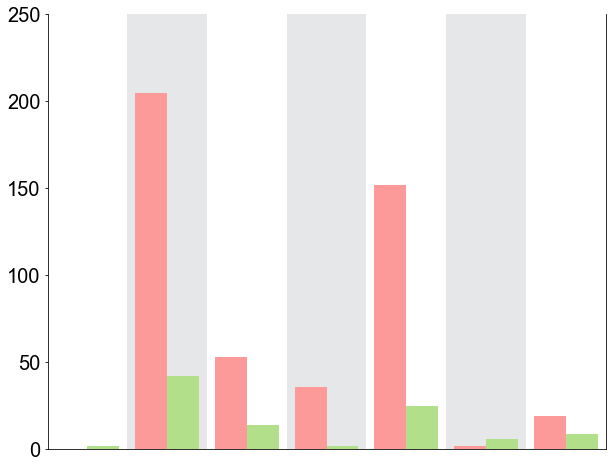

In [245]:
ds = [MWU_av_AT_IFEC_ds, MWU_av_AT_IFEB_ds, MWU_av_AT_IFED_ds, MWU_av_AT_IFEM_ds, MWU_av_AT_uHFB_ds, MWU_av_AT_uHFD_ds, MWU_av_AT_OB_ds]
thr = -np.log10(0.05)
cmap = {'A':cmap_time['5w'],'T':cmap_time['9w']}

#initialize figure

height = 8
width = 10

plt.figure(facecolor = 'w', figsize = (width, height))
ax = plt.subplot(111)
ax.spines['top'].set_color('none')
#ax.spines['right'].set_color('none')

#set x-axis

ax.set_xlim(-0.5, len(ds) * 2 - 0.5)
ax.set_xticks([])

#set y-axis

ax.set_ylim(0, 250)
ax.set_yticks([0,50,100,150,200,250])
ax.set_yticklabels([0,50,100,150,200,250], family = 'Arial', fontsize = 20)
#ax.set_ylabel('Number of induced genes', family = 'Arial', fontsize = 25)

#iterate over datasets

for pos, d in enumerate(ds):
    
    if pos % 2 == 0:
        ax.axvspan(pos * 2 - 0.5, pos * 2 + 1.5, color = '#FFFFFF', zorder = 0)
            
    if pos % 2 == 1:
        ax.axvspan(pos * 2 - 0.5, pos * 2 + 1.5, color = '#E6E7E8', zorder = 0)
        
    for ix,t in [(0.1,'A'),(0.9,'T')]:
        ax.bar(pos * 2 + ix, np.sum(np.sum(d[t]>thr)), color = cmap[t], width = 0.8)
        
figname = 'v1.5_FigS3_genes_up_AT.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Plot selected anagen and telogen associated genes

## IFE basal

In [246]:
cl_c_IFEB_AT = pd.Series()

for c in c_sel_IFEB_A: cl_c_IFEB_AT[c] = 'IFEB_A'
for c in c_sel_IFEB_T: cl_c_IFEB_AT[c] = 'IFEB_T'

In [247]:
shade_pos = [(0, len(c_sel_IFEB_A))]

In [248]:
genes = ['mt-Cytb','Oat','Pkm','Ndufa4l2','Atp5j','Sfn','Avpi1','Mt1']

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


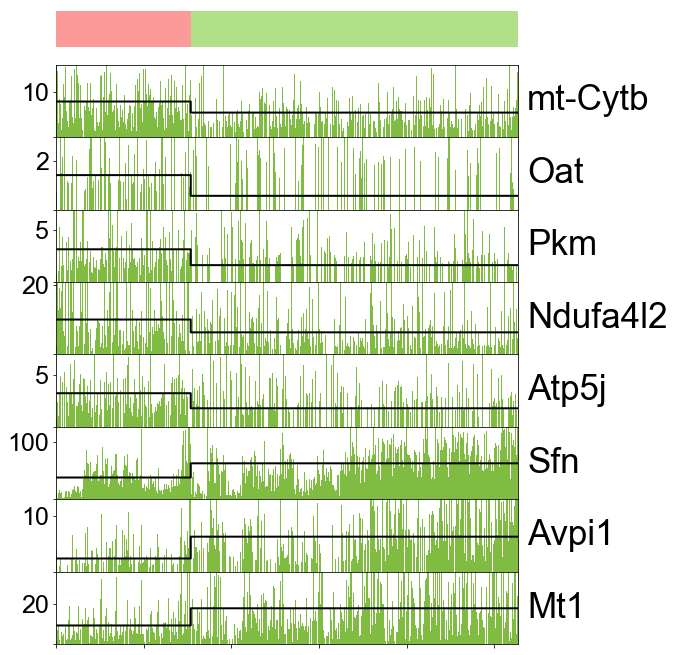

In [250]:
cell_groups = cl_c_IFEB_AT
dataset = seqN[cl_c_IFEB_AT.index]
#genes = ['Sfn']
cmap = {'IFEB_A':'#7fbc41','IFEB_T':'#7fbc41'}

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 9
height = len(genes) * 1.1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
            
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 35, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        ax0.locator_params(axis='y', nbins=2)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for pos, c in enumerate(cell_groups.index):
    
    ax1.axvspan(xmin = pos, xmax = pos + 1, color = cmap_time[cells_stage[c]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

figname = 'v1.5_Fig2_bar_AT_IFEB.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


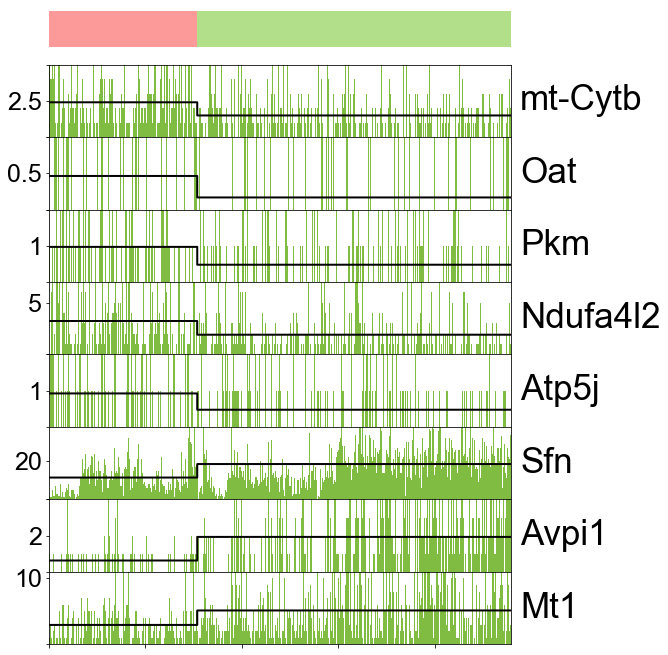

In [251]:
cell_groups = cl_c_IFEB_AT[[c for c in cl_c_IFEB_AT.index if c in seq_EPI_ds.columns]]
dataset = seq_EPI_ds[cell_groups.index]
#genes = ['Sfn']
cmap = {'IFEB_A':'#7fbc41','IFEB_T':'#7fbc41'}

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 9
height = len(genes) * 1.1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
            
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 35, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        ax0.locator_params(axis='y', nbins=2)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for pos, c in enumerate(cell_groups.index):
    
    ax1.axvspan(xmin = pos, xmax = pos + 1, color = cmap_time[cells_stage[c]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

figname = 'v1.5_Fig2_bar_AT_IFEB_ds.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## uHF basal

In [252]:
cl_c_uHFB_AT = pd.Series()

for c in c_sel_uHFB_A: cl_c_uHFB_AT[c] = 'uHFB_A'
for c in c_sel_uHFB_T: cl_c_uHFB_AT[c] = 'uHFB_T'

In [253]:
shade_pos = [(0, len(c_sel_uHFB_A))]

In [254]:
genes = ['Marcksl1','Ucp2','Ostc','mt-Nd1','Tpi1','Krt17','Sfn','Mt1']

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


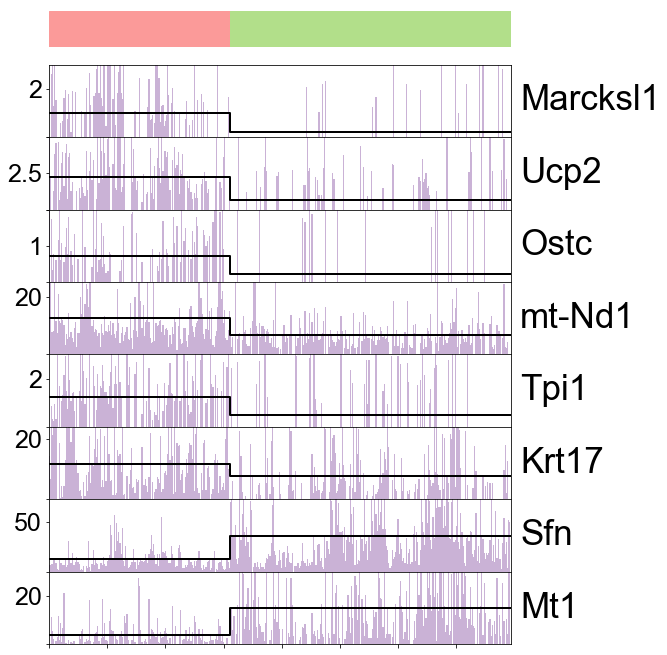

In [255]:
cell_groups = cl_c_uHFB_AT
dataset = seqN[cl_c_uHFB_AT.index]
#genes = ['Krt17']
cmap = {'uHFB_A':'#cab2d6','uHFB_T':'#cab2d6'}

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 9
height = len(genes) * 1.1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
            
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 35, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        ax0.locator_params(axis='y', nbins=2)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for pos, c in enumerate(cell_groups.index):
    
    ax1.axvspan(xmin = pos, xmax = pos + 1, color = cmap_time[cells_stage[c]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

figname = 'v1.5_Fig2_bar_AT_uHFB.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


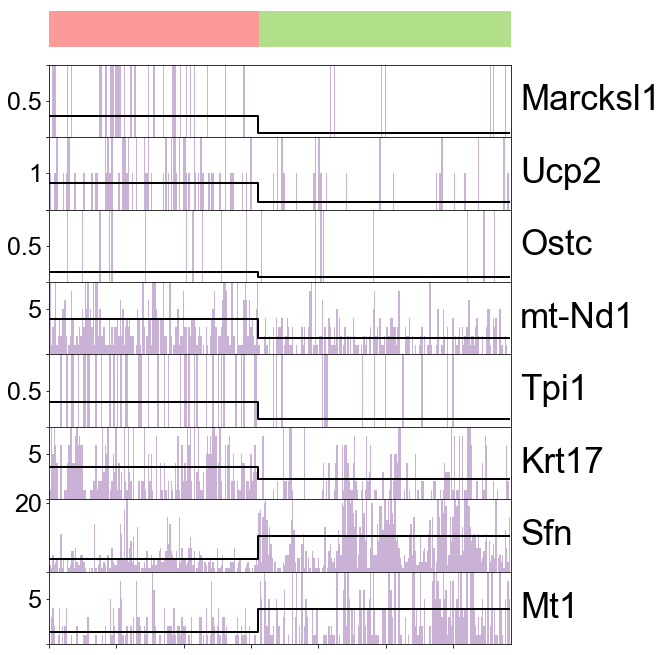

In [256]:
cell_groups = cl_c_uHFB_AT[[c for c in cl_c_uHFB_AT.index if c in seq_EPI_ds.columns]]
dataset = seq_EPI_ds[cell_groups.index]
#genes = ['Krt17']
cmap = {'uHFB_A':'#cab2d6','uHFB_T':'#cab2d6'}

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 9
height = len(genes) * 1.1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
            
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 35, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        ax0.locator_params(axis='y', nbins=2)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for pos, c in enumerate(cell_groups.index):
    
    ax1.axvspan(xmin = pos, xmax = pos + 1, color = cmap_time[cells_stage[c]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

figname = 'v1.5_Fig2_bar_AT_uHFB_ds.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Outer bulge

In [257]:
cl_c_OB_AT = pd.Series()

for c in c_sel_OB_A: cl_c_OB_AT[c] = 'OB_A'
for c in c_sel_OB_T: cl_c_OB_AT[c] = 'OB_T'

In [258]:
shade_pos = [(0, len(c_sel_OB_A))]

In [259]:
genes = ['mt-Cytb','Barx2','Dbi','Ucp2','Them5','Gpx1','Cd34','Ftl1']

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


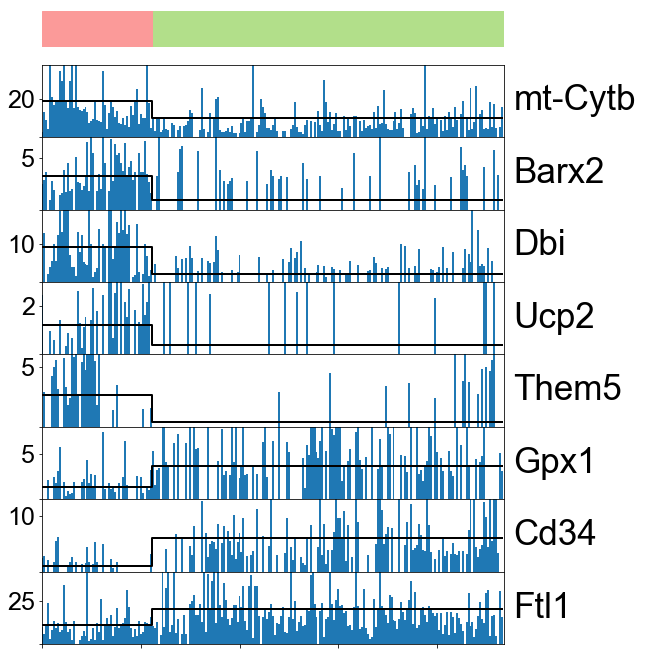

In [260]:
cell_groups = cl_c_OB_AT
dataset = seqN[cl_c_OB_AT.index]
#genes = ['Gpx1']
cmap = {'OB_A':'#1f78b4','OB_T':'#1f78b4'}

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 9
height = len(genes) * 1.1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 35, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        ax0.locator_params(axis='y', nbins=2)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for pos, c in enumerate(cell_groups.index):
    
    ax1.axvspan(xmin = pos, xmax = pos + 1, color = cmap_time[cells_stage[c]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

figname = 'v1.5_Fig2_bar_AT_OB.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/Users/simjoo/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


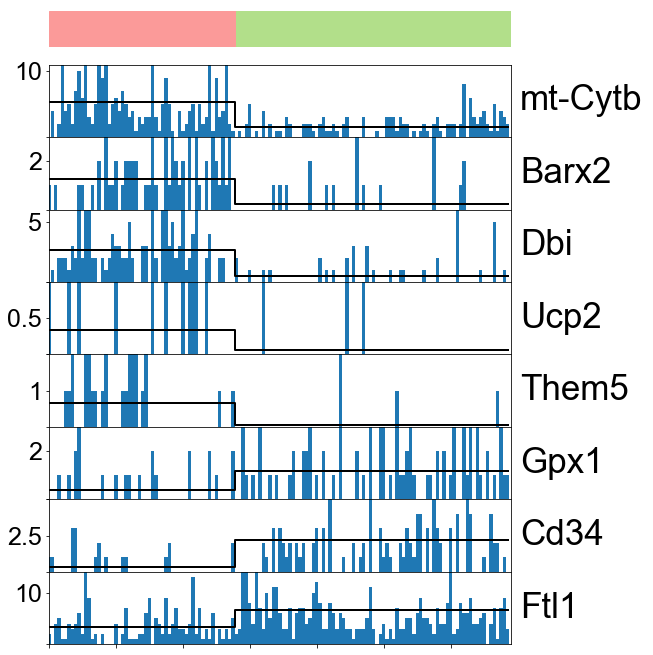

In [261]:
cell_groups = cl_c_OB_AT[[c for c in cl_c_OB_AT.index if c in seq_EPI_ds.columns]]
dataset = seq_EPI_ds[cell_groups.index]
#genes = ['Gpx1']
cmap = {'OB_A':'#1f78b4','OB_T':'#1f78b4'}

#create figure

bar_size = 0.5
bar_pad = 0.25
width = 9
height = len(genes) * 1.1

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#create GS for gene barplots

gs1 = plt.GridSpec(len(genes), 2, hspace = 0.00, wspace = 0.0, top = 1 - ((bar_pad + bar_size) / height), right = 1, 
                   left = (bar_pad + bar_size) / width, bottom = 0, width_ratios = [14,4])

#create GS for sample group bar

gs0 = plt.GridSpec(1,2, left = (bar_pad + bar_size) / width, right = 1, top = 1,
                       bottom = 1 - ((bar_size) / height), hspace = 0.0, wspace = 0.0, width_ratios = [14,4])

#colorlist bar

clistBAR = [cmap[val] for val in cell_groups]

#draw genes

for g in genes:
    
        #create group_specific mean expressions
    
        mean_tmp = pd.Series(index = set(cell_groups))
        
        for gr in set(cell_groups):
            
            ix_tmp = cell_groups[cell_groups == gr].index
            mean_tmp[gr] = dataset.ix[g, ix_tmp].mean()
            
        #create white space for gene names
        
        ax0 = plt.subplot(gs1[genes.index(g),1])
        clean_axis(ax0)
 
        #create axis
            
        ax0 = plt.subplot(gs1[genes.index(g),0])
        
        ax0.axvspan(0, len(dataset.columns), color = '#FFFFFF', zorder = 0)
        
        #define xaxis
        
        ax0.set_xlim(left = 0, right = (len(dataset.columns)))
        ax0.xaxis.set_ticklabels([])
        
        #define yaxis
        
        ax0.set_ylim(bottom = 0, top = np.ceil(np.max(mean_tmp) * 2))
        ax0.set_ylabel(g, family = 'Arial', fontsize = 35, rotation = 'horizontal', va = 'center', ha = 'left')
        ax0.yaxis.set_label_coords(1.02, 0.5)
        
        ax0.locator_params(axis='y', nbins=2)
        
        for tick_pos, tick in enumerate(ax0.yaxis.get_major_ticks()):
            if tick_pos % 2 == 1:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)
            else:
                ax0.yaxis.get_major_ticks()[tick_pos].label.set_visible(False)
                
        #draw expression data
        
        ax0.bar(np.arange(0, len(dataset.columns),1), dataset.ix[g], color = clistBAR, linewidth = 0, width = 1.0)
        
        #draw means
        
        ax0.step(range(len(cell_groups)), [mean_tmp[val] for val in cell_groups], where = 'mid', color = 'black', linewidth = 2)

ax1 = plt.subplot(gs0[0,0])

ax1.set_xlim(0, len(cell_groups))

for pos, c in enumerate(cell_groups.index):
    
    ax1.axvspan(xmin = pos, xmax = pos + 1, color = cmap_time[cells_stage[c]])

remove_ticks(ax1, linewidth = 1)
clean_axis(ax1)

figname = 'v1.5_Fig2_bar_AT_OB_ds.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Cell-cell distance

In [262]:
seq_sel_EPI = loadData_v1(path_output, exp_id, 'seq_sel_EPI', 'DataFrame')

In [263]:
seq_sel_EPI_pca, dist_c_EPI = dim_reduc_pca(seq_sel_EPI, 15, 'euclidean', inverse_transform = False)

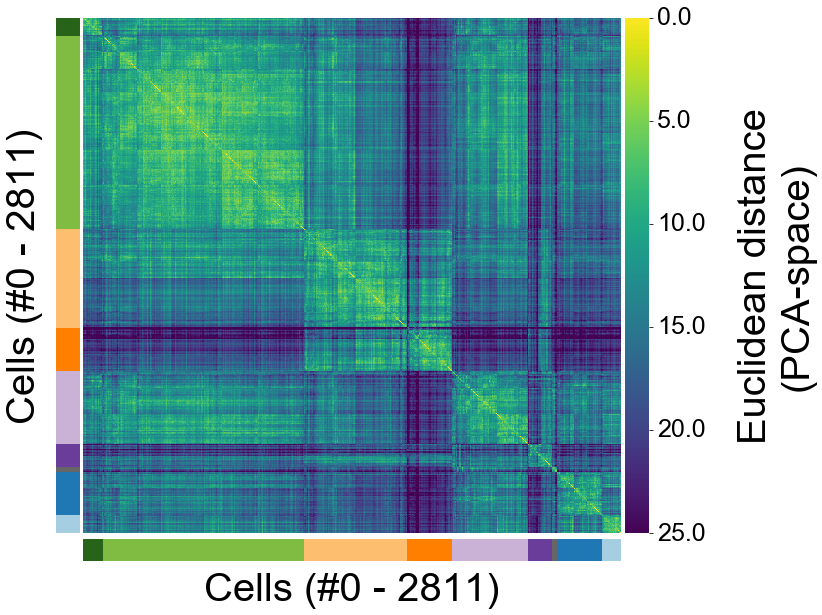

In [264]:
groups = cl_c_EPI
dist = dist_c_EPI
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_2nd

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS3_cell_cell_distance_EPI.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Comparison to Seurat

In [33]:
cl_c_EPI_S = pd.read_csv('%s/Seurat/TenX_2ndLevel_Epi_ClusterIdentity.txt' % path_output, sep = '\t', header = None, index_col = 0, 
                           low_memory = False, squeeze = True)

In [34]:
tsne_EPI_S = pd.read_csv('%s/Seurat/TenX_2ndLevel_EPI_TSNEcoordinates.txt' % path_output, sep = '\t', index_col = 0, header = 0)
tsne_EPI_S.columns = ['x','y']

In [35]:
c_sel = list(set(cl_c_EPI_S.index) & set(cl_c_EPI.index))
cl_c_EPI_S = AP_groups_reorder_v2(cl_c_EPI_S[c_sel], return_unique(cl_c_EPI_S[c_sel]))

## Fuse Seurat clusters to represent main compartments of permanent epidermis

In [39]:
cl_c_EPI_S_sel = pd.Series('None', index = cl_c_EPI_S.index)

cl_c_EPI_S_sel[cl_c_EPI_S.isin([11])] = 'EPI - 0'
cl_c_EPI_S_sel[cl_c_EPI_S.isin([0,3,4,6])] = 'EPI - 1'
cl_c_EPI_S_sel[cl_c_EPI_S.isin([1,7])] = 'EPI - 2'
cl_c_EPI_S_sel[cl_c_EPI_S.isin([8])] = 'EPI - 3'
cl_c_EPI_S_sel[cl_c_EPI_S.isin([2])] = 'EPI - 4'
cl_c_EPI_S_sel[cl_c_EPI_S.isin([9])] = 'EPI - 5'
cl_c_EPI_S_sel[cl_c_EPI_S.isin([12])] = 'EPI - 6'
cl_c_EPI_S_sel[cl_c_EPI_S.isin([5])] = 'EPI - 7'
cl_c_EPI_S_sel[cl_c_EPI_S.isin([10])] = 'EPI - 8'

In [40]:
cl_c_EPI_S_sel = AP_groups_reorder_v2(cl_c_EPI_S_sel, ['EPI - 0','EPI - 1','EPI - 2','EPI - 3','EPI - 4','EPI - 5','EPI - 6','EPI - 7','EPI - 8'])

## tSNE

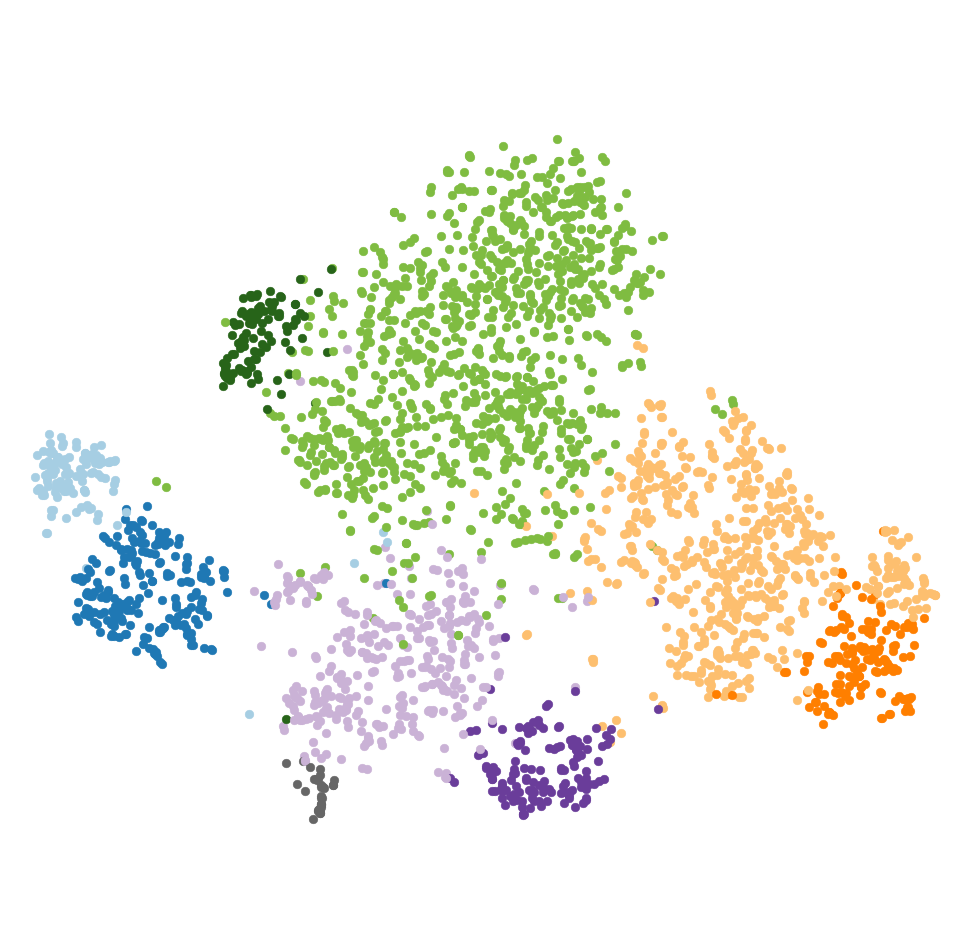

In [270]:
cells = cl_c_EPI_S_sel
tsne = tsne_EPI_S.loc[cells.index]
cmap = cmap_2nd
time = cells_stage
markers = markers_time

#initialize figure

height = 17
width = 17

fig = plt.figure(facecolor = 'w', figsize = (width, height))

#define x- and y-limits

x_min, x_max = np.min(tsne['x']), np.max(tsne['x'])
y_min, y_max = np.min(tsne['y']), np.max(tsne['y'])
x_diff, y_diff = x_max - x_min, y_max - y_min

pad = 2.0

if x_diff > y_diff:
    xlim = (x_min - pad, x_max + pad)
    ylim = (y_min * (x_diff / y_diff) - pad, y_max * (x_diff / y_diff) + pad)

if x_diff < y_diff:
    xlim = (x_min * (y_diff/x_diff) - pad, x_max * (y_diff/x_diff) + pad)
    ylim = (y_min - pad, y_max + pad)

text_pad = 2
    
#draw groups

ax1 = plt.subplot()

ax1.set_xlim(xlim[0], xlim[1])
ax1.set_ylim(ylim[0], ylim[1])

remove_ticks(ax1)

index = list(tsne.index)
np.random.shuffle(index)

for ix in index:

    ax1.scatter(tsne.loc[ix,'x'],
                tsne.loc[ix,'y'], 
                s = 75,
                linewidth = 0.5,
                c = cmap[cells[ix]],
                edgecolor=cmap[cells[ix]], 
                marker = markers[time[ix]])

clean_axis(ax1)

figname = 'v1.5_FigS3_tSNE_epi_Seurat.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Cell-cell-distance

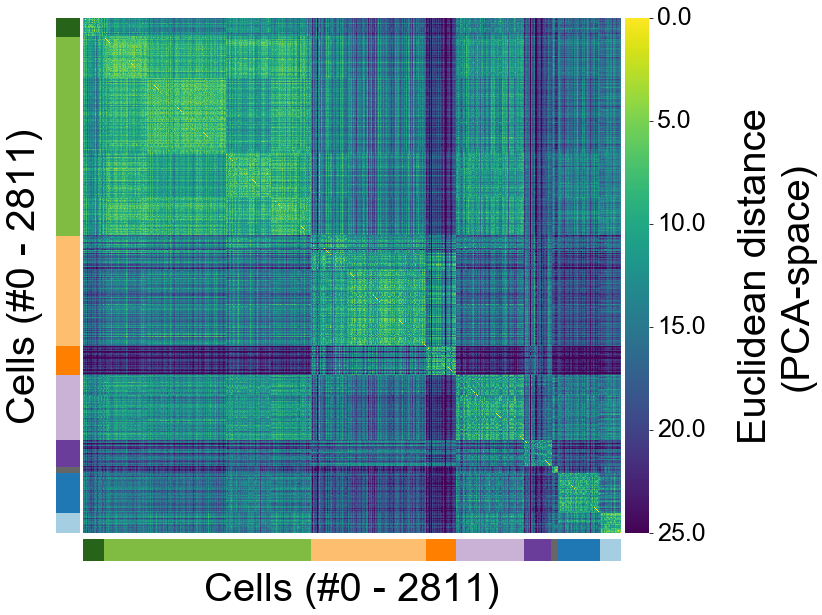

In [272]:
groups = cl_c_EPI_S_sel
dist = dist_c_EPI
dist = dist.loc[groups.index, groups.index]
vmin = 0
vmax = 25
cmap = plt.cm.viridis_r
cmap_groups = cmap_2nd

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (10.625, 10))
gs = plt.GridSpec(nrows = 2, ncols = 3, wspace=0.02, hspace=0.02, width_ratios=[0.5 , 11.25, 0.5], height_ratios=[11.25, 0.5])

#plot heatmap

axHM = plt.subplot(gs[0, 1])

axHM.matshow(dist, cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax, interpolation = None)
    
axHM.set_xlabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)
axHM.set_ylabel('Cells (#0 - %s)' % len(groups), family = 'Arial', fontsize = 40)

axHM.xaxis.set_label_coords(0.5, -0.075)
axHM.yaxis.set_label_coords(-0.075, 0.5)
    
axHM.set_yticks([])

clean_axis(axHM)

#plot left sample groups

axSG1 = plt.subplot(gs[0, 0])

axSG1.set_ylim(len(groups), 0)

for pos, gr in enumerate(groups):
    axSG1.axhspan(pos, pos+1, color=cmap_groups[gr])
    
remove_ticks(axSG1)
clean_axis(axSG1)

#plot bottom sample groups

axSG2 = plt.subplot(gs[1, 1])

axSG2.set_xlim(0, len(groups))

for pos, gr in enumerate(groups):
    axSG2.axvspan(pos, pos+1, color=cmap_groups[gr])

remove_ticks(axSG2)
clean_axis(axSG2)

#plot label

axLabel = plt.subplot(gs[0,2])

axLabel.matshow(np.matrix(np.arange(vmin, vmax, 0.1)).T,
                cmap = cmap, aspect = 'auto', vmin = vmin, vmax = vmax)

axLabel.xaxis.set_ticks([])
axLabel.yaxis.set_ticks_position('right')

clean_axis(axLabel)

axLabel.set_yticks(np.linspace(axLabel.get_ylim()[0], axLabel.get_ylim()[1], 6))
axLabel.set_yticklabels(np.linspace(vmax, vmin, 6), family = 'Arial', fontsize = 25, va = 'center')
axLabel.tick_params(axis='y', which='major', pad=5)

axLabel.set_ylabel('Euclidean distance\n(PCA-space)', family = 'Arial', fontsize = 40)
axLabel.yaxis.set_label_coords(8, 0.5)

figname = 'v1.5_FigS3_cell_cell_distance_EPI_Seurat.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Comparison

In [273]:
def heatmap_diag(hm):
    
    import operator
    
    #get dict and sort
    
    d = {}
    
    for r in hm.index:
        for c in hm.columns:
            d[(r,c)] = hm.loc[r,c]
            
    r_sort, c_sort = [], []
            
    d = sorted(d.items(), key=operator.itemgetter(1), reverse = True)
    
    for i in d:
        if i[0][0] not in r_sort and i[0][1] not in c_sort:
            r_sort += [i[0][0]]
            c_sort += [i[0][1]]
    
    r_sort += [r for r in hm.index if r not in r_sort]
    c_sort += [c for c in hm.columns if c not in c_sort]
    
    return hm.loc[r_sort, c_sort]

In [49]:
def seurat_vs_AP(cl_ix, cl_col, return_counts = False):
    
    #define output
    
    output_perc = pd.DataFrame(index = return_unique(cl_ix), columns = return_unique(cl_col))
    output_count = pd.DataFrame(index = return_unique(cl_ix), columns = return_unique(cl_col))
    
    for col in return_unique(cl_col):
        ix_col = set(cl_col[cl_col==col].index)
        
        for row in return_unique(cl_ix):
            ix_row = set(cl_ix[cl_ix==row].index)
            
            output_perc.loc[row, col] = float(len(ix_row&ix_col)) / float(len(ix_row))
            output_count.loc[row, col] = float(len(ix_row&ix_col))
    
    if return_counts == True:
        return heatmap_diag(output_perc), output_count
    else:    
        return heatmap_diag(output)

In [50]:
seurat_vs_AP_EPI_perc, seurat_vs_AP_EPI_count = seurat_vs_AP(cl_c_EPI, cl_c_EPI_S_sel, True)

In [51]:
overlap_EPI_ax0 = seurat_vs_AP_EPI_count.max(axis=0).sum() / seurat_vs_AP_EPI_count.sum().sum()
overlap_EPI_ax1 = seurat_vs_AP_EPI_count.max(axis=1).sum() / seurat_vs_AP_EPI_count.sum().sum()

In [277]:
print(overlap_EPI_ax0, overlap_EPI_ax1)

0.9018143009605123 0.9018143009605123


In [41]:
from sklearn.metrics import adjusted_rand_score as rand

In [46]:
rand_EPI = rand(cl_c_EPI, cl_c_EPI_S_sel)

In [47]:
rand_EPI

0.8876942864104954

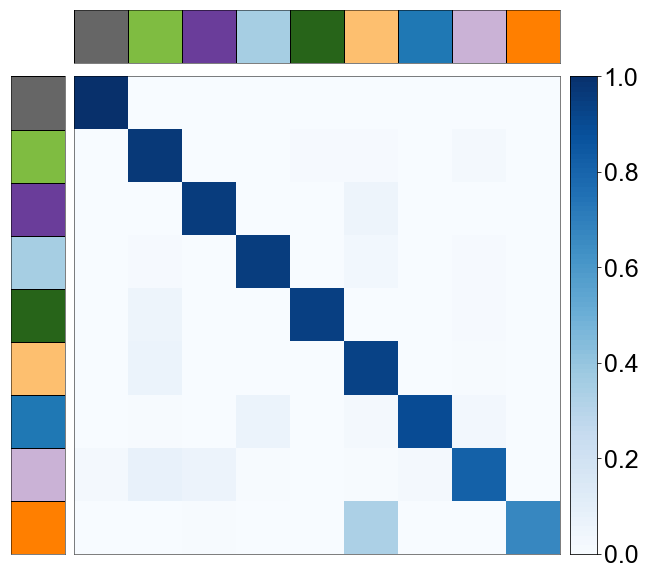

In [278]:
data = seurat_vs_AP_EPI_perc

cmap_ix = cmap_2nd
cmap_col = cmap_2nd

#generate figure

fig = plt.figure(facecolor = 'w', figsize = (len(data.columns) + 1.5, len(data.index) + 1))
gs = plt.GridSpec(nrows = 2, ncols = 3, 
                  wspace=0.05, width_ratios=[1,1*len(data.columns),0.5], 
                  hspace=0.05, height_ratios=[1,1*len(data.index)])

#plot population colors

ax = plt.subplot(gs[1,0])

ax.set_ylim(len(data.index), 0)

for pos, gr in enumerate(data.index):
    ax.axhspan(pos, pos + 1, color = cmap_ix[gr])
    ax.axhline(pos, lw = 1, color = 'k')
    
remove_ticks(ax)

ax = plt.subplot(gs[0,1])

ax.set_xlim(0, len(data.columns))

for pos, gr in enumerate(data.columns):
    ax.axvspan(pos, pos + 1, color = cmap_col[gr])
    ax.axvline(pos, lw = 1, color = 'k')
    
remove_ticks(ax)

#plot data

ax = plt.subplot(gs[1,1])

ax.imshow(data.astype(float),
          cmap = plt.cm.Blues,
          aspect = 'auto',
          interpolation = 'nearest',
          vmin = 0, vmax = 1)

remove_ticks(ax)

#plot legend

ax = plt.subplot(gs[1,2])

ax.set_ylim(0,1)
ax.set_xticks([])

ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], family = 'Arial', fontsize = 25)
ax.yaxis.set_ticks_position('right')

for pos in np.arange(0,1,0.01):
    ax.axhspan(pos, pos + 0.01, color = plt.cm.Blues(pos))
    
figname = 'v1.5_FigS3_seurat_AP_comp_EPI.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Differentially expressed genes

## Import scripts and data

In [279]:
def MWU_get_binarized(mwu_pval, cutoff, neglog = True):
    
    output = pd.DataFrame(index = mwu_pval.index, columns = mwu_pval.columns).fillna(0)
    
    if neglog == True:
        output[mwu_pval>=cutoff] = 1
    else:
        output[mwu_pval<cutoff] = 1
    
    return output

In [280]:
def MWU_extract_genes_(mwu_pval, mwu_bin, number = 10, neglog = True):
    
    output = pd.DataFrame(index = range(number), columns = mwu_bin.columns).fillna('None')
    
    for gr in mwu_bin.columns:
        g_bin = mwu_bin[gr][mwu_bin[gr]==1].index
        
        if neglog == True:
            g_sel = mwu_pval.loc[g_bin, gr].sort_values()[-number:].index[::-1]
            #return g_sel
        else:
            g_sel = mwu_pval.loc[g_bin, gr].sort_values()[number:].index
            
        output.loc[range(len(g_sel)), gr] = g_sel
        
    return output

## Compared to average

In [281]:
mwu_av_EPI[mwu_av_EPI==np.inf] = 307

In [282]:
mwu_av_EPI_bin = MWU_get_binarized(mwu_av_EPI, -np.log10(0.001), neglog = True)

In [283]:
mwu_av_EPI_genes = MWU_extract_genes_(mwu_av_EPI, mwu_av_EPI_bin, number = 10, neglog = True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize

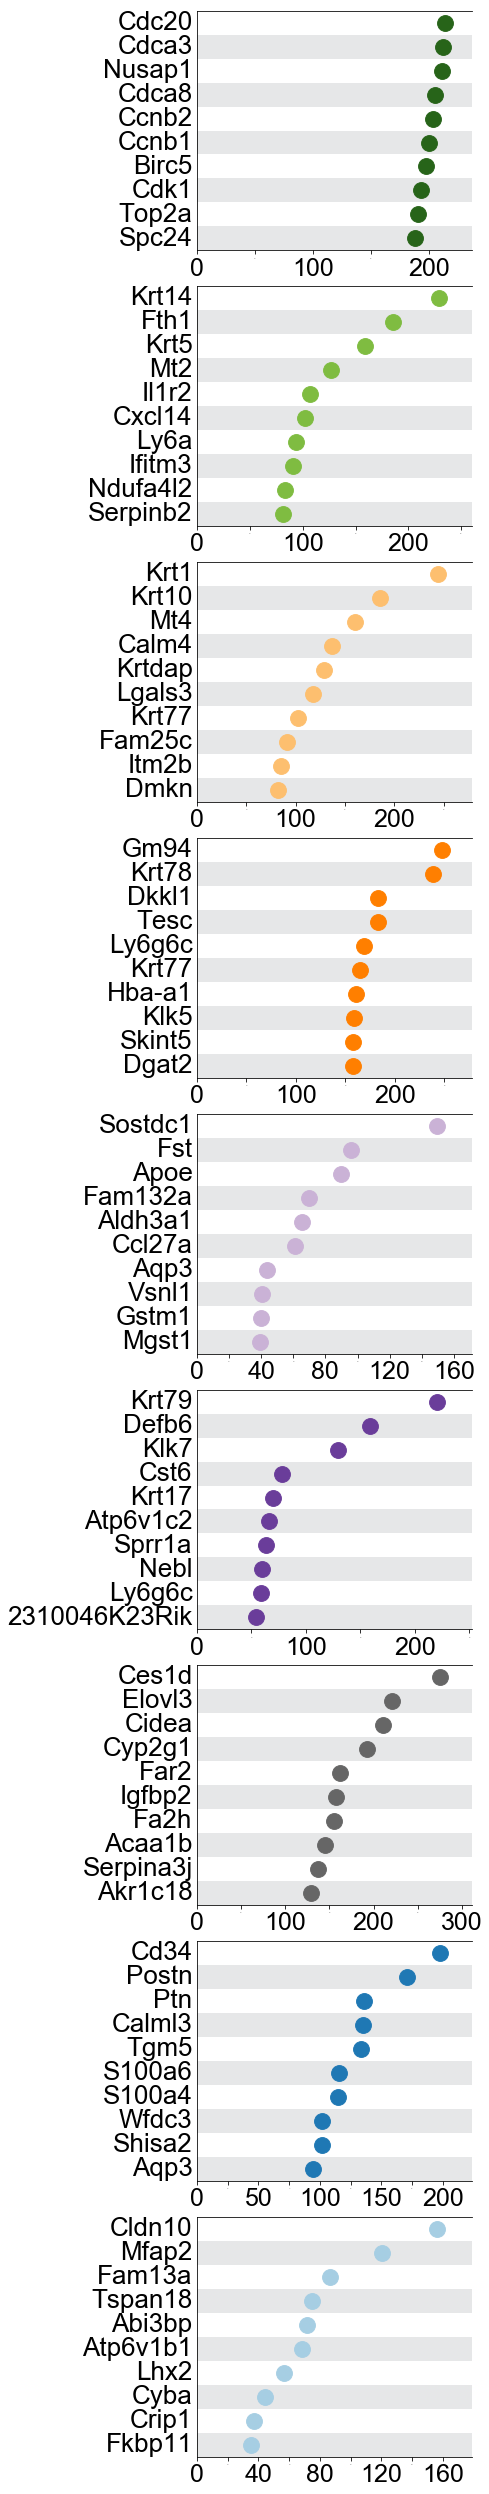

In [284]:
#define input variables

gr_order = return_unique(cl_c_EPI)
genes = mwu_av_EPI_genes
L = len(genes.index)
pval = mwu_av_EPI
cmap = cmap_2nd

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.5_FigS3_MWU_vs_av_EPI.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Compared to groups

In [285]:
mwu_gr_EPI[mwu_gr_EPI==np.inf] = 307

In [286]:
mwu_gr_EPI_bin = MWU_get_binarized(mwu_gr_EPI, -np.log10(0.001), neglog = True)

In [287]:
mwu_gr_EPI_bin.sum()

EPI - 0    65
EPI - 1     0
EPI - 2     0
EPI - 3    63
EPI - 4     1
EPI - 5     9
EPI - 6    64
EPI - 7     6
EPI - 8     6
dtype: int64

In [288]:
mwu_gr_EPI_genes = MWU_extract_genes_(mwu_gr_EPI, mwu_gr_EPI_bin, number = 10, neglog = True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize

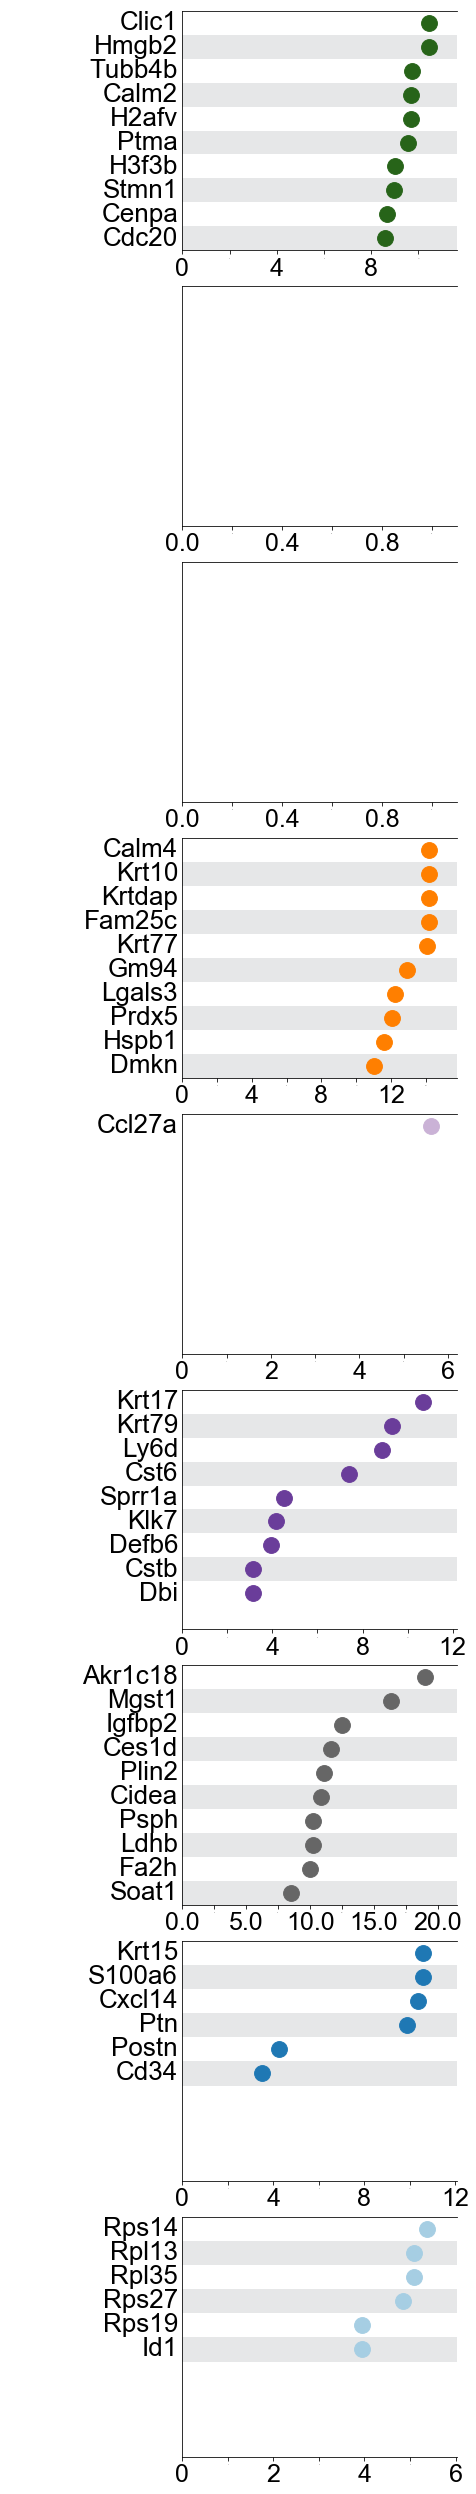

In [289]:
#define input variables

gr_order = return_unique(cl_c_EPI)
genes = mwu_gr_EPI_genes
L = len(genes.index)
pval = mwu_gr_EPI
cmap = cmap_2nd

#initialize figure

height = 5 * len(gr_order)
width = 8

plt.figure(facecolor = 'w', figsize = (width, height))
gs = plt.GridSpec(len(gr_order), 2, hspace = 0.15, wspace = 0.0, width_ratios = [5,8])

#iterate through groups

for pos, gr in enumerate(gr_order):
    
    genes_tmp = [gene for gene in genes[gr].values if gene != 'None']
    
    #create gene name axis 
    
    ax0 = plt.subplot(gs[pos,0])
    ax0.set_ylim(L - 0.5, -0.5)
    clean_axis(ax0)
    
    #create violin plot axis
    
    ax1 = plt.subplot(gs[pos,1])
    
    ax1.spines['right'].set_color('none')

    ax1.set_ylim(L - 0.5, -0.5)
    ax1.yaxis.set_ticks_position('left')
    ax1.yaxis.set_ticks([])
    
    #iterate over genes
    
    for ix, g in enumerate(genes_tmp):
        ax0.text(0.975, ix, g, family = 'Arial', fontsize = 26, ha = 'right', va = 'center')
        
        #print background
        
        if ix % 2 == 0:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#FFFFFF', zorder = 0)
            
        if ix % 2 == 1:
            ax1.axhspan(ix - 0.5, ix + 0.5, color = '#E6E7E8', zorder = 0)
            
        #print pvals
        
        ax1.scatter(pval.loc[g,gr], ix, marker = 'o', s = 250, color = cmap[gr])
        
    xlim = list(ax1.get_xlim())

    ax1.set_xlim(0, xlim[1] * 1.1)

    for ix, t in enumerate(ax1.xaxis.get_ticklabels()):
        if ix % 2 == 0:
            t.set_family('Arial')
            t.set_fontsize(25)
        else:
            t.set_fontsize(0)
            
figname = 'v1.5_FigS3_MWU_vs_gr_EPI.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)